In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
import os

In [13]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [14]:
with open(f"./names.txt") as file:
    words = file.readlines()
# print(words)
words = [word.strip() for word in words]
    

In [15]:
# Store alphabet from data
alphabet = set()

# For every character of each word
for word in words:
    for char in word:
        alphabet.add(char)
        
# Add start and end tokens
alphabet.add('<S>')
alphabet.add('<E>')
alphabet = sorted(alphabet)

In [16]:
# Store numeric conversions of tokens
tok_to_int = dict()
int_to_tok = dict()

# Iterate across entire alphabet
for i, token in enumerate(alphabet):
    tok_to_int[token] = i
    int_to_tok[i] = token

In [17]:
# Define Window Size 
window_size = 3

# Store training vardiables
X = []
Y = []

#Iterate over each word
for word in words:

    # Store initial window of padding
    window = [tok_to_int["<S>"] for _ in range(window_size)]
    # Add ending token to word
    word = list(word) + ['<E>']

    # Store edge case training point
    X.append(window) 
    # Store edge case target
    Y.append(tok_to_int[word[0]]) #T
    # Iterate over each character + padding
    for char1, char2 in zip(word[:], word[1:]):
        # Store training data and targets
        # print(window)
        window = window[1:] + [tok_to_int[char1]]
        # Store window in training set
        X.append(window)
        # print(tok_to_int[char2])
        Y.append(tok_to_int[char2])

        
X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [18]:
# Define variables
len_of_emb = 3
nuerons_in_first_layer = 100
# Second layer = final layer
nuerons_in_second_layer = 28
# Store words embeddings with 2 features
C = torch.rand(len(alphabet), len_of_emb, requires_grad=True, device=device)

# Store dataset via embeddings
input_emb = C[X].view(-1, window_size*len_of_emb).to(torch.float32)
input_emb.requires_grad_(True)
# target_emb = F.one_hot(Y, num_classes=28)

# # Store weights and bias
W1 = torch.rand(window_size*len_of_emb, nuerons_in_first_layer, requires_grad=True, dtype=torch.float32, device=device)
B1 = torch.rand(nuerons_in_first_layer, requires_grad=True, dtype=torch.float32, device=device)

W2 = torch.rand(nuerons_in_first_layer, nuerons_in_second_layer, requires_grad=True, dtype=torch.float32, device=device)
B2 = torch.rand(nuerons_in_second_layer,requires_grad=True, dtype=torch.float32, device=device)

parameters = [C, W1, W2, B1, B2]
# Check dimensions
# print(embed.T.shape, W1.shape, B1.shape)
# print(embed.T.shape, W2.shape, B2.shape)

In [19]:
# # Test out single pass 
# # Calculate linear layer
# logits = (input_emb @ W1) + B1

# # Apply Softmax
# softmax = F.softmax(logits, dim=1)

# # Calculate loss from negative log likelihood, (loss used in GLM)
# lik = softmax[torch.arange(len(softmax)), Y]

# neg_log_lik = lik.log() * -1

# loss = neg_log_lik.mean().item()

# # Calculate loss using built-in function

# simple_loss = F.cross_entropy(input=logits, target=Y)
# print(simple_loss)
# print(simple_loss.item())

In [20]:
# Store hyperparameters
num_of_epochs = 10000
# learning_rate = .0001

# Optimization data
lr_line = torch.linspace(-3, 0, num_of_epochs) # for choosing optimal lr
lr_exp = 10 ** lr_line #this transformations yields values between .001 and 1
# print(lr_exp)
# store learning and loss sequentially
lr_tracking = []
loss_tracking = []


In [23]:

def mini_batch(size=128):
    indices = torch.randint(0, X.shape[0], (size,), device=device)
    batch_X = X[indices]
    batch_input_emb = C[batch_X].view(-1, window_size*len_of_emb).to(torch.float32)
    return batch_input_emb, Y[indices]

# define foward pass
def foward_pass(inputs):
    # First Layer
    int_result = F.tanh((inputs @ W1) + B1)
    # Second/Output Layer
    logits = (int_result @ W2) + B2
    return logits

# Training for num of epochs
for epoch in range(num_of_epochs):
    # Get mini batch
    training_data, targets = mini_batch()
    training_data.to(device)
    targets.to(device)
    # Zero out gradients
    for p in parameters:
        if p.grad is not None:
            param.grad.zero_() #inplace
    # Foward pass
    logits = foward_pass(training_data)
    # Calculate Loss (Note: learned about two function "log_softmax" and "F.nll_loss")
    loss = F.cross_entropy(input=logits, target=targets, reduction='mean')
    # backpropogation
    loss.backward()
    torch.nn.utils.clip_grad_norm_(parameters, max_norm=1.0)
    lr = 10**(-1.5)
    print
    # lr = lr_exp[epoch] #Store 
    # # store loss and active lr
    loss_tracking.append(loss.item())
    # lr_tracking.append(lr_line[epoch].item()) # tracks by exponent
    # update weights give learning rate
    for p in parameters:
        # Ensure updates arent added to computation graph
        with torch.no_grad():
            for param in parameters:
                # update in the opposite direction of the gradient
                param -= .00001 * param.grad
    
    
    if epoch % 100 == 0:
        # Output training info
        print(F"Epoch: {epoch}, Loss: {loss.item()}")
    
    
    

Epoch: 0, Loss: 3.2753422260284424
Epoch: 100, Loss: 3.290160655975342
Epoch: 200, Loss: 3.2255563735961914
Epoch: 300, Loss: 3.5927062034606934
Epoch: 400, Loss: 3.2471539974212646
Epoch: 500, Loss: 3.1916518211364746
Epoch: 600, Loss: 3.42390513420105
Epoch: 700, Loss: 2.8818304538726807
Epoch: 800, Loss: 3.3089842796325684
Epoch: 900, Loss: 3.1742429733276367
Epoch: 1000, Loss: 3.1365606784820557
Epoch: 1100, Loss: 3.138590097427368
Epoch: 1200, Loss: 3.2841601371765137
Epoch: 1300, Loss: 3.151442766189575
Epoch: 1400, Loss: 3.14707088470459
Epoch: 1500, Loss: 3.2821357250213623
Epoch: 1600, Loss: 3.027500629425049
Epoch: 1700, Loss: 3.1730241775512695
Epoch: 1800, Loss: 3.136500120162964
Epoch: 1900, Loss: 3.222909927368164
Epoch: 2000, Loss: 3.456232786178589
Epoch: 2100, Loss: 3.2072737216949463
Epoch: 2200, Loss: 3.2293083667755127
Epoch: 2300, Loss: 3.21309494972229
Epoch: 2400, Loss: 3.2709591388702393
Epoch: 2500, Loss: 3.3164708614349365
Epoch: 2600, Loss: 3.1754262447357178

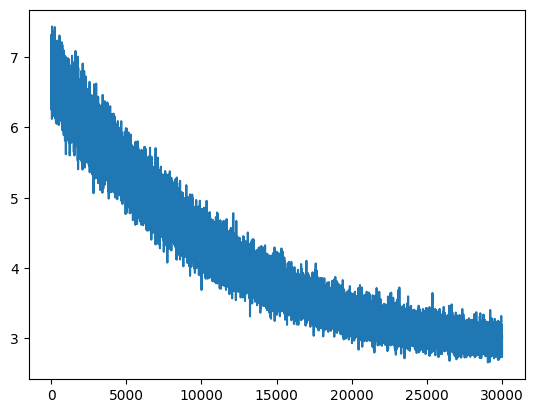

In [24]:
plt.plot(loss_tracking)